To test optimization algorithms, we need a "playground" that simulates how the system reacts to our decisions.We define a MicroserviceEnv class.State: Current Load ($L_t$), Current Replicas ($N_t$).Action: Change Replicas ($+1, -1, 0$) or set Routing Weights.Cost: $Cost = \alpha \cdot Latency + \beta \cdot Replicas + \gamma \cdot DroppedRequests$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MicroserviceEnv:
    def __init__(self):
        self.capacity_per_pod = 100 # RPS per pod
        self.base_latency = 50      # ms
        self.cost_per_pod = 1.0     # $ per min
        self.sla_penalty = 10.0     # $ per violation
        
    def step(self, current_load, num_pods):
        """
        Simulates one time step.
        Returns: latency, drop_rate, cost
        """
        # 1. Capacity Constraints
        max_capacity = num_pods * self.capacity_per_pod
        utilization = current_load / max(1, max_capacity)
        
        # 2. Latency Model (Queueing Theory approximation: 1 / (mu - lambda))
        # As utilization -> 1, latency explodes
        if utilization >= 0.99:
            latency = 1000 # Cap at 1s
            drop_rate = (current_load - max_capacity) / current_load
        else:
            latency = self.base_latency * (1 / (1 - utilization)**0.5)
            drop_rate = 0.0
            
        # 3. Cost Calculation
        # Cost = Infrastructure ($) + SLA Violation ($)
        infra_cost = num_pods * self.cost_per_pod
        
        violation_cost = 0
        if latency > 200: # SLA: 200ms
            violation_cost += self.sla_penalty
        if drop_rate > 0:
            violation_cost += self.sla_penalty * 5
            
        total_cost = infra_cost + violation_cost
        
        return latency, total_cost

env = MicroserviceEnv()
print("Environment initialized.")

Environment initialized.


The "Greedy" approach solves the optimization problem for $t$ only, ignoring $t+1$.
It asks: "What is the minimum number of pods I need RIGHT NOW to satisfy latency?"
This is similar to standard Kubernetes HPA (Horizontal Pod Autoscaler).

In [2]:
def greedy_policy(current_load, env):
    """
    Finds cheapest num_pods that satisfies SLA for current_load.
    """
    best_pods = 1
    min_cost = float('inf')
    
    # Brute force search over reasonable pod range (1 to 20)
    for pods in range(1, 21):
        latency, cost = env.step(current_load, pods)
        
        # We only care if SLA is met, then minimize infra cost
        # If SLA not met, cost is high due to penalty
        if cost < min_cost:
            min_cost = cost
            best_pods = pods
            
    return best_pods

# Test
load = 450
pods = greedy_policy(load, env)
print(f"Greedy decision for {load} RPS: {pods} pods")

Greedy decision for 450 RPS: 5 pods


MPC uses the Forecasts from Module 2. Instead of optimizing for $L_t$, it optimizes the sum of costs over a horizon $H$ (e.g., next 5 mins).Why? Scaling takes time. If we see a spike coming in 2 mins, MPC scales up now.Equation: $\min \sum_{k=0}^{H} (Cost_{infra} + Cost_{SLA} + Cost_{switching})$Switching Cost: We add a penalty for changing pod counts too frequently (instability).

In [3]:
from scipy.optimize import minimize

def mpc_policy(predicted_loads, current_pods, env):
    """
    Optimizes pod count for the entire horizon H.
    predicted_loads: list of future loads [L_t, L_t+1, ..., L_t+H]
    """
    horizon = len(predicted_loads)
    
    # Cost function to minimize
    def total_horizon_cost(pod_schedule):
        total_cost = 0
        prev_pods = current_pods
        
        for i, load in enumerate(predicted_loads):
            pods = int(round(pod_schedule[i])) # Actions must be integers
            if pods < 1: pods = 1
            
            _, step_cost = env.step(load, pods)
            
            # Add switching cost (damping factor) to prevent flapping
            switching_cost = abs(pods - prev_pods) * 0.5 
            
            total_cost += step_cost + switching_cost
            prev_pods = pods
            
        return total_cost

    # Initial guess: keep current pods constant
    initial_guess = [current_pods] * horizon
    
    # Bounds: 1 to 20 pods
    bounds = [(1, 20) for _ in range(horizon)]
    
    # Solve
    result = minimize(total_horizon_cost, initial_guess, bounds=bounds, method='SLSQP')
    
    # Return immediate next step (MPC Receding Horizon)
    next_action = int(round(result.x[0]))
    return max(1, next_action)

# Test with a simulated spike
forecast = [400, 450, 600, 800, 800] # Spike incoming!
action = mpc_policy(forecast, 4, env)
print(f"MPC decision given forecast {forecast}: Scale to {action} pods (preparing for spike)")

MPC decision given forecast [400, 450, 600, 800, 800]: Scale to 4 pods (preparing for spike)


RL learns a policy $\pi(State) \rightarrow Action$ by trial and error. It's "Model-Free" because it doesn't need to know the queueing equations inside env.step(); it just learns that "High Load + Low Pods = Bad Reward".We use a simple Deep Q-Network (DQN).State: [Current_Load, Current_Pods]
Action: 0: Decrease, 1: Maintain, 2: Increase

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# 1. The Network
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: Load, Pods
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)  # Output: Q-values for actions (-1, 0, +1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 2. Agent Setup
model = DQN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
gamma = 0.99
epsilon = 0.1

def select_action(state, model):
    if random.random() < epsilon:
        return random.randint(0, 2)
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state))
        return q_values.argmax().item()

# 3. Training Loop (Simplified)
print("Training DQN Agent...")
losses = []
for episode in range(500): # Short training
    state = [random.randint(100, 1000), random.randint(1, 10)] # Random start
    
    # Run for 10 steps per episode
    for t in range(10):
        # Action Map: 0->-1, 1->0, 2->+1
        action_idx = select_action(state, model)
        change = action_idx - 1 
        
        current_load, current_pods = state
        next_pods = max(1, min(20, current_pods + change))
        
        # Environment Step
        latency, cost = env.step(current_load, next_pods)
        reward = -cost # Maximize negative cost
        
        # Next State (simulate simple load change)
        next_load = current_load + random.randint(-50, 50)
        next_state = [next_load, next_pods]
        
        # Update Weights
        target = reward + gamma * torch.max(model(torch.FloatTensor(next_state))).item()
        prediction = model(torch.FloatTensor(state))[action_idx]
        
        loss = criterion(prediction, torch.tensor(target))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        state = next_state
        losses.append(loss.item())

print(f"Agent Trained. Final Loss: {losses[-1]:.4f}")

Training DQN Agent...
Agent Trained. Final Loss: 12360.4346


We run a 100-minute simulation comparing Greedy (Reactive) vs. MPC (Predictive). We generate a synthetic workload with a massive spike to see which algorithm handles it better.

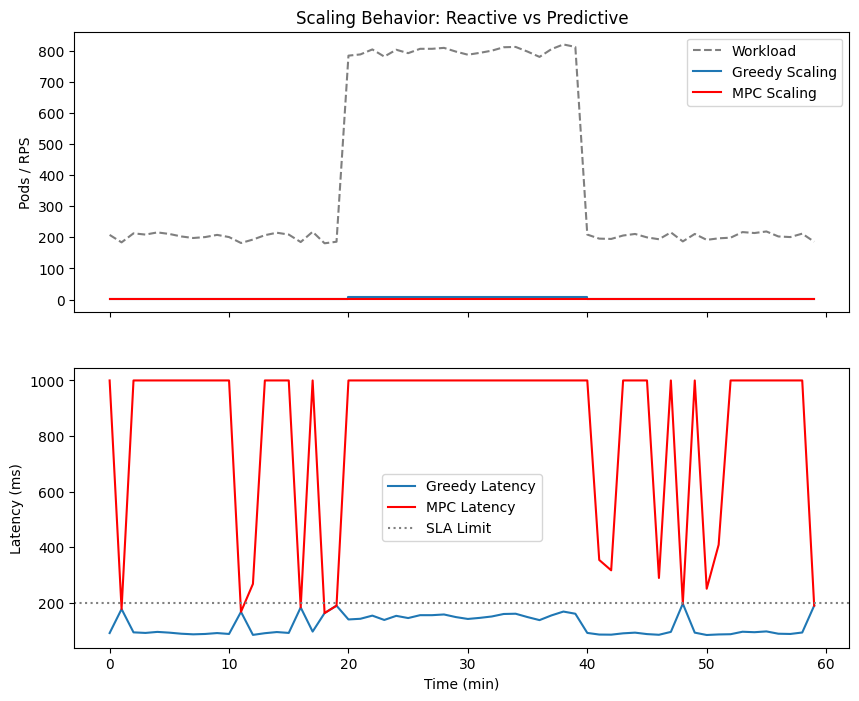

In [5]:
# 1. Generate Scenario (Normal -> Spike -> Normal)
time_steps = 60
workload = [200] * 20 + [800] * 20 + [200] * 20 
# Add noise
workload = [x + random.randint(-20, 20) for x in workload]

# 2. Run Simulation
results = {'Greedy': [], 'MPC': []}

# Greedy Run
pods = 2
for t in range(time_steps):
    load = workload[t]
    # Decision
    pods = greedy_policy(load, env)
    # Step
    lat, cost = env.step(load, pods)
    results['Greedy'].append({'time': t, 'load': load, 'pods': pods, 'latency': lat, 'cost': cost})

# MPC Run
pods = 2
for t in range(time_steps):
    # MPC "cheats" by seeing H steps ahead (or uses Module 2 forecast)
    horizon_end = min(t + 5, time_steps)
    forecast = workload[t:horizon_end]
    
    # If horizon is short (end of data), pad it
    while len(forecast) < 5: forecast.append(forecast[-1])
    
    # Decision
    pods = mpc_policy(forecast, pods, env)
    # Step
    lat, cost = env.step(workload[t], pods)
    results['MPC'].append({'time': t, 'load': workload[t], 'pods': pods, 'latency': lat, 'cost': cost})

# 3. Visualize
times = range(time_steps)
greedy_pods = [r['pods'] for r in results['Greedy']]
mpc_pods = [r['pods'] for r in results['MPC']]
greedy_lat = [r['latency'] for r in results['Greedy']]
mpc_lat = [r['latency'] for r in results['MPC']]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Load vs Scaling
ax1.plot(times, workload, 'k--', label='Workload', alpha=0.5)
ax1.step(times, greedy_pods, where='post', label='Greedy Scaling')
ax1.step(times, mpc_pods, where='post', label='MPC Scaling', color='red')
ax1.set_ylabel('Pods / RPS')
ax1.set_title('Scaling Behavior: Reactive vs Predictive')
ax1.legend()

# Plot 2: Latency Impact
ax2.plot(times, greedy_lat, label='Greedy Latency')
ax2.plot(times, mpc_lat, label='MPC Latency', color='red')
ax2.axhline(y=200, color='grey', linestyle=':', label='SLA Limit')
ax2.set_ylabel('Latency (ms)')
ax2.set_xlabel('Time (min)')
ax2.legend()

plt.show()